### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 12th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

### Solution

In [120]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy import optimize
from scipy.stats import norm
from scipy.stats import laplace

### Part 1

In [2]:
#reading in data
data = np.load('/Users/petrop3/Repos/astr_8070_s22/coursework/homeworks/hw_data/hw3_data_1.npy')
data_vals = data[:,0]
data_unc = data[:,1]

Computing sample mean according to:
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

and standard error on sample mean according to:
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [10]:
#computing sample mean
xbar = sum(data_vals/data_unc**2) / sum(1/data_unc**2)
print('Sample mean:',xbar)

#computing std error on sample mean for heteroscedastic gaussian
sigma_mu = (sum(1/data_unc**2))**(-1/2)
print('Standard error on sample mean:',sigma_mu)

Sample mean: 3.917992034606058
Standard error on sample mean: 0.09481084100510956


### Part 2

Using the following equation for lnL (and ignoring the constant):

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [22]:
#want to find the mean that maximizes the log likelihood (or minimizes -logL)

#function for log likelihood
def log_lh(data,uncert,mean):
    ll = -(sum((data-mean)**2 / (2*uncert**2) ))
    return ll

min_X2 = lambda m: -1*(log_lh(data_vals,data_unc,m)) #multiplying by -1 as we want to minimize -logL with scipy

opt_mean = optimize.fmin(min_X2, x0=0) #initial guess of mean=0
print('Best fit mean:',opt_mean[0])

Optimization terminated successfully.
         Current function value: 43.162545
         Iterations: 29
         Function evaluations: 58
Best fit mean: 3.918000000000005


### Part 3

In [40]:
xgrid = np.linspace(0,8,1000) #array of possible values for the mean
L = []
for x in xgrid:
    L.append(log_lh(data_vals,data_unc,x)) #calculating log likelihood for each value of the mean
sig_mu = np.diff(L, n=2)
sig_mu /= (xgrid[1]-xgrid[0])**2
sig_mu *= -1
sig_mu = 1/np.sqrt(sig_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sig_mu)

Fisher matrix error on estimated mean is 0.095


### Part 4

In [78]:
#defining bootstrap function, which takes array of data, array of uncertainries, and number of bootstraps as inputs
def bootstrap(data,uncert,B):
    indices = np.arange(0,len(data),1) #list of possible indices to choose from based on length of data array
    bs_realizations = []
    for i in range(B):
        index = np.random.choice(indices,len(data)) #choosing indices with replacement, match length with data array
        resample = np.array([data[index],uncert[index]]) #an array with data and uncertainties for each realization
        bs_realizations.append(resample) #adding resampled realization to array containing all new realizations
    return bs_realizations

datasets = bootstrap(data_vals, data_unc, 1000)

### Part 5

In [91]:
#finding the best fit mean for each realization
means = []
for d in datasets:
    min_X2 = lambda m: -1*(log_lh(d[0], d[1], m)) #0th element of each realization is data, 1st element is uncert
    mn = optimize.fmin(min_X2, x0=0)
    means.append(mn[0]) #taking 0th element because mn comes out as a 1-element array

Optimization terminated successfully.
         Current function value: 46.013750
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 34.183969
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 52.962599
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 43.981450
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 39.590270
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 47.332051
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 44.198008
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 35.947126
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 36.688768
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 52.736007
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 45.665432
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 42.333855
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 41.798268
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 38.213964
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 45.069726
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 50.516719
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 38.314430
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 42.412028
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 34.722761
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 48.598393
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 36.673904
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 52.480304
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 40.610171
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 41.332528
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 42.443165
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 37.975335
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 39.060672
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 42.492859
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 52.230704
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 31.884475
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 36.408491
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 37.366583
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 43.827266
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 39.445958
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 44.479039
         Iterations: 29
   

Optimization terminated successfully.
         Current function value: 40.621522
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 35.412327
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 38.778059
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 35.066747
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 40.536268
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 46.660685
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 43.859875
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 45.572711
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 50.617067
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 37.948840
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 33.146532
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 41.408463
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 40.152271
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 39.732974
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 40.221600
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 40.184457
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 39.483736
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 44.398933
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 52.124740
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 35.900158
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 47.488709
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 48.543830
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 45.203371
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 46.438174
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 53.064240
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 40.845759
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 41.652390
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 40.350537
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 39.440200
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 41.979909
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 31.375289
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 49.564415
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 46.761822
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 39.150013
         Iterations: 29
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: 47.357791
         Iterations: 29
         Function evaluations: 58
Optimization terminated suc

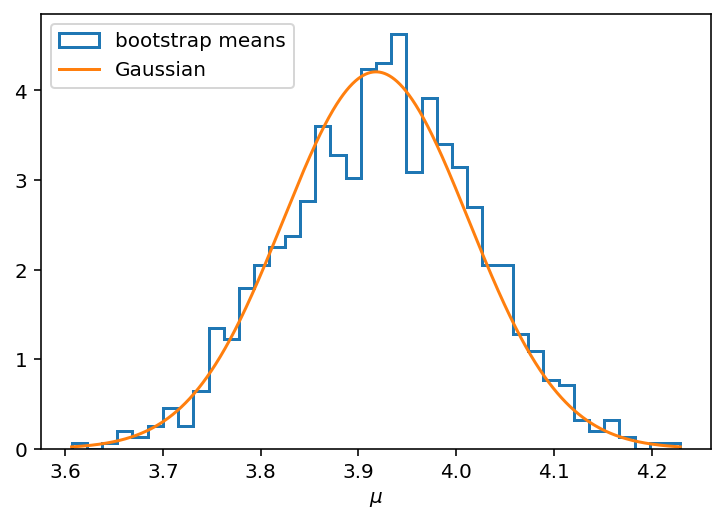

In [109]:
#plotting normalized histogram of bootstrap means
_ = plt.hist(means, bins=40, histtype='step', lw=1.5, density=True, label='bootstrap means')

#Gaussian with mean and std dev found in part 1
Xs = np.linspace(min(means), max(means), 1000)
distG = norm(xbar, sigma_mu)
plt.plot(Xs, distG.pdf(Xs), lw=1.5, label='Gaussian')

plt.xlabel('$\mu$')
plt.legend(loc='upper left')
plt.show()

The two distributions seem to agree pretty well!

### Part 6

Defining log likelihood for a Laplacian distribution using the following:

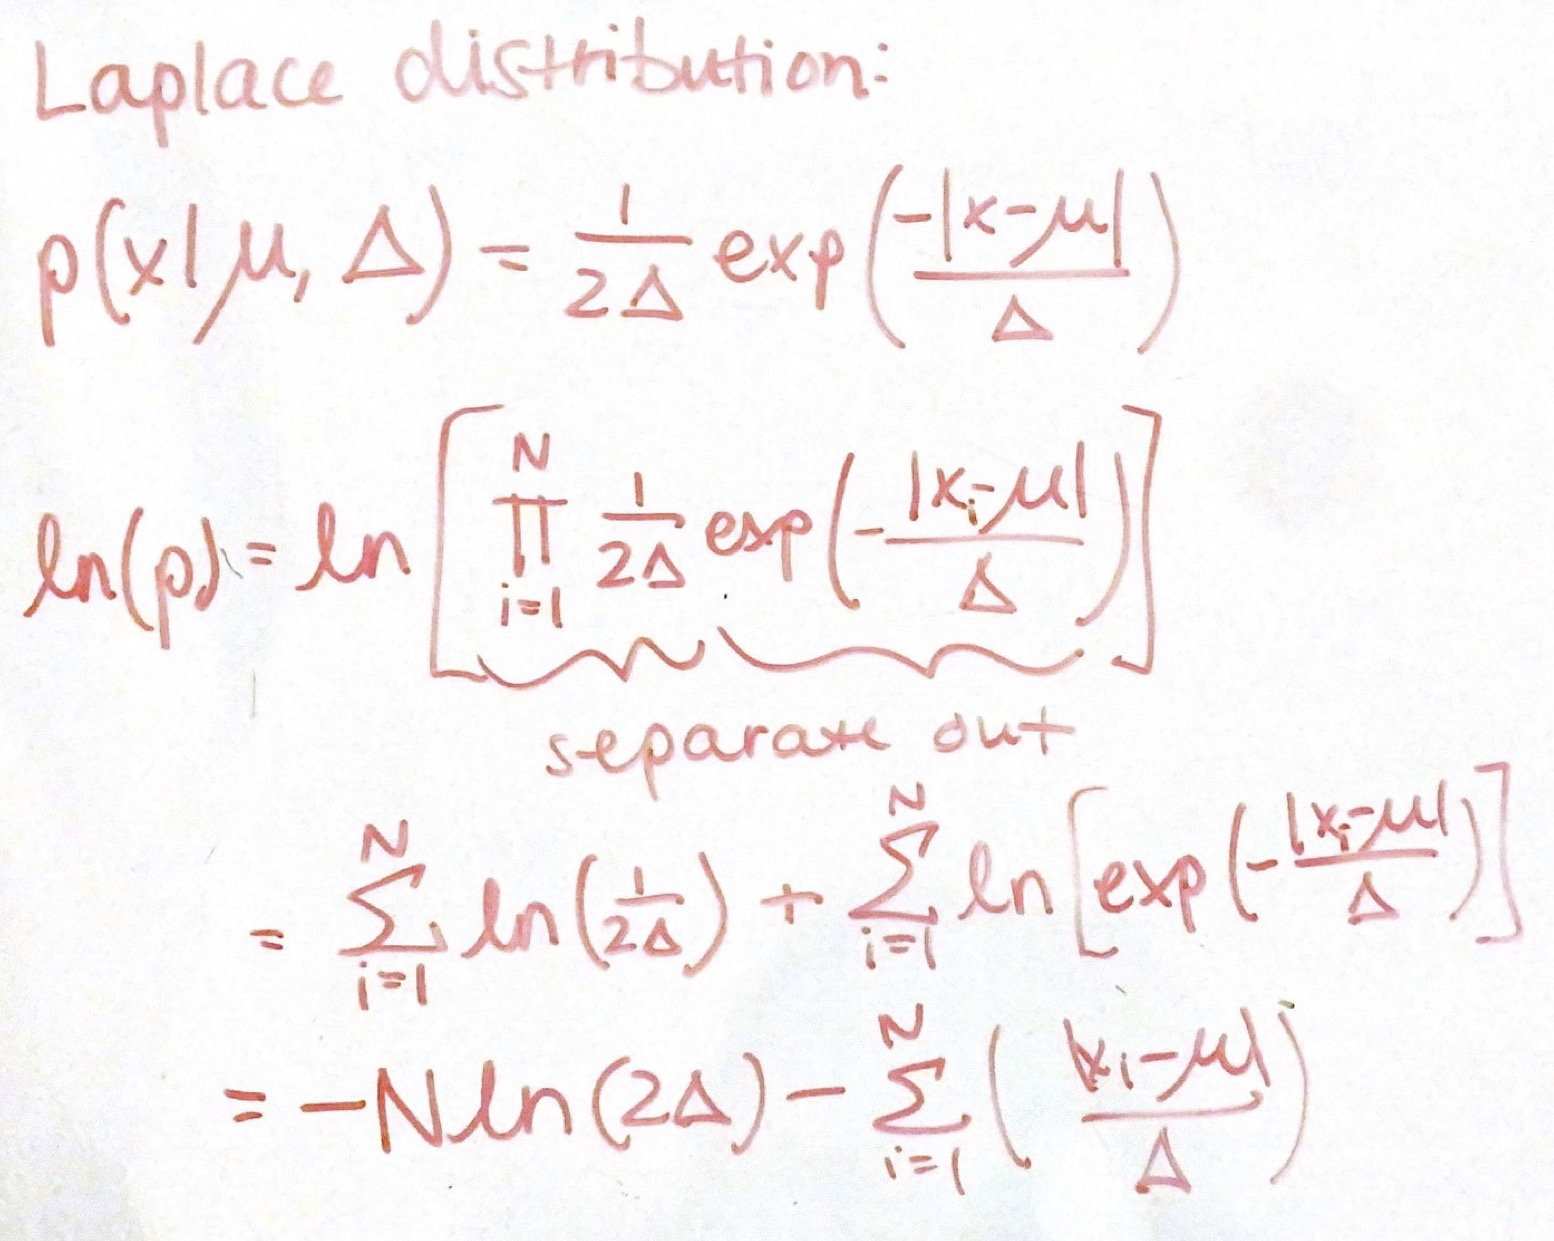

In [124]:
#function for laplacian log likelihood
def logLH_laplace(data,mu,delta):
    ll = -len(data)*np.log(2*delta) - sum(np.abs(data-mu)/delta)
    return ll

In [125]:
#minimizing negative log likelihood, optimizing both mu and delta
neg_ll = lambda params: -1*(logLH_laplace(data_vals,params[0],params[1]))

guess = (0,1) #initial guess of mu=0, delta=1
opt = optimize.fmin(neg_ll, x0=guess) 
print('Best fit mu:',opt[0])
print('Best fit delta:',opt[1])

Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 90
         Function evaluations: 175
Best fit mu: 4.087760794214727
Best fit delta: 0.882269232732088


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_18341/2734315147.py:3: RuntimeWarning: invalid value encountered in log
  ll = -len(data)*np.log(2*delta) - sum(np.abs(data-mu)/delta)


### Part 7

Using the following to compute AIC value:
$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

In [128]:
#computing AIC for gaussian model
#using log likelihood function defined in (2): inputs are data and uncertainties from file, optimized mean found in (2)
#k=1 model parameter, the mean
#N=len(data_vals) number of data points
L0_g = log_lh(data_vals,data_unc,opt_mean)
AIC_g = -2*L0_g + 2*1 + (2*1*(1+1)/(len(data_vals)-1-1))
print('AIC for heteroscedastic Gaussian model:', AIC_g)

#computing AIC for laplacian model
#using log likelihood function defined in (6): inputs are data from file, optimized mu and delta found in (6)
#k=2 model parameters, mu and delta
#N=len(data_vals) number of data points
L0_l = logLH_laplace(data_vals,opt[0],opt[1])
AIC_l = -2*L0_l + 2*2 + (2*2*(2+1)/(len(data_vals)-2-1))
print('AIC for Laplacian model:', AIC_l)

AIC for heteroscedastic Gaussian model: 88.36590702652268
AIC for Laplacian model: 317.70154369338627


The heteroscedastic Gaussian model is favored by the data as it has a lower AIC value.

### Part 8

In [129]:
#finding the best fit mu and delta for each bootstrapped dataset
best_fits = []
for d in datasets:
    neg_ll = lambda params: -1*(logLH_laplace(d[0],params[0],params[1])) #0th element of each realization is the data
    best = optimize.fmin(neg_ll, x0=(0,1)) #using mu=0, delta=1 as initial guesses again
    best_fits.append(best)

/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_18341/2734315147.py:3: RuntimeWarning: invalid value encountered in log
  ll = -len(data)*np.log(2*delta) - sum(np.abs(data-mu)/delta)


Optimization terminated successfully.
         Current function value: 160.296005
         Iterations: 78
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 135.967082
         Iterations: 77
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 167.785691
         Iterations: 92
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 148.153600
         Iterations: 97
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 156.636365
         Iterations: 83
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 164.669302
         Iterations: 89
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 149.392746
         Iterations: 90
         Function evaluations: 167
Optimization 

Optimization terminated successfully.
         Current function value: 153.513611
         Iterations: 84
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 171.058505
         Iterations: 93
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 148.408654
         Iterations: 85
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 163.125927
         Iterations: 90
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 161.792839
         Iterations: 84
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 170.389854
         Iterations: 95
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 168.892710
         Iterations: 96
         Function evaluations: 184
Optimization 

Optimization terminated successfully.
         Current function value: 152.900502
         Iterations: 87
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 165.036546
         Iterations: 98
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 160.680099
         Iterations: 94
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 147.866383
         Iterations: 94
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 142.089730
         Iterations: 92
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 154.785786
         Iterations: 94
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 157.960908
         Iterations: 81
         Function evaluations: 156
Optimization 

Optimization terminated successfully.
         Current function value: 171.961655
         Iterations: 91
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 160.617900
         Iterations: 96
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 160.474442
         Iterations: 95
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 144.838297
         Iterations: 92
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 159.566847
         Iterations: 81
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 146.664686
         Iterations: 97
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 148.757565
         Iterations: 81
         Function evaluations: 149
Optimization 

Optimization terminated successfully.
         Current function value: 148.752464
         Iterations: 83
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 148.142704
         Iterations: 90
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 153.217478
         Iterations: 84
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 166.389326
         Iterations: 88
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 144.640475
         Iterations: 90
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 151.738186
         Iterations: 97
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 145.551668
         Iterations: 87
         Function evaluations: 160
Optimization 

Optimization terminated successfully.
         Current function value: 132.765973
         Iterations: 84
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 146.407906
         Iterations: 98
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 154.115294
         Iterations: 90
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 154.635032
         Iterations: 78
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 165.662310
         Iterations: 83
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 149.553781
         Iterations: 98
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 153.159929
         Iterations: 89
         Function evaluations: 168
Optimization 

Optimization terminated successfully.
         Current function value: 163.679984
         Iterations: 94
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 151.861550
         Iterations: 96
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 150.594393
         Iterations: 92
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 145.815441
         Iterations: 95
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: 150.322752
         Iterations: 90
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 171.362771
         Iterations: 92
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 160.476829
         Iterations: 83
         Function evaluations: 154
Optimization 

Optimization terminated successfully.
         Current function value: 149.841970
         Iterations: 90
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 153.125225
         Iterations: 86
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 155.940257
         Iterations: 88
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 151.931292
         Iterations: 103
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 151.610758
         Iterations: 85
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 155.511036
         Iterations: 82
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 151.665300
         Iterations: 94
         Function evaluations: 181
Optimization

Optimization terminated successfully.
         Current function value: 145.916271
         Iterations: 88
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 158.514467
         Iterations: 92
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 143.086061
         Iterations: 86
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 146.229194
         Iterations: 90
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 154.341640
         Iterations: 83
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 132.522311
         Iterations: 99
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 151.100768
         Iterations: 84
         Function evaluations: 158
Optimization 

Optimization terminated successfully.
         Current function value: 157.429241
         Iterations: 92
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 149.434510
         Iterations: 88
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 150.248839
         Iterations: 90
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 152.415663
         Iterations: 96
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: 145.857427
         Iterations: 84
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: 166.165259
         Iterations: 91
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 155.438485
         Iterations: 95
         Function evaluations: 176
Optimization 

Optimization terminated successfully.
         Current function value: 154.329037
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 160.866796
         Iterations: 84
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 152.447179
         Iterations: 91
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 150.736738
         Iterations: 87
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: 155.955748
         Iterations: 88
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 168.527608
         Iterations: 99
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 156.809718
         Iterations: 87
         Function evaluations: 162
Optimization 

Optimization terminated successfully.
         Current function value: 158.297733
         Iterations: 79
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 166.221855
         Iterations: 83
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 162.897468
         Iterations: 96
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 166.335689
         Iterations: 98
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 157.309190
         Iterations: 94
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 166.119209
         Iterations: 96
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 151.667479
         Iterations: 83
         Function evaluations: 155
Optimization 

Optimization terminated successfully.
         Current function value: 161.647556
         Iterations: 94
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 164.784508
         Iterations: 81
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 155.033850
         Iterations: 88
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 146.446571
         Iterations: 86
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 162.301032
         Iterations: 95
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 162.404606
         Iterations: 90
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 150.116125
         Iterations: 87
         Function evaluations: 164
Optimization 

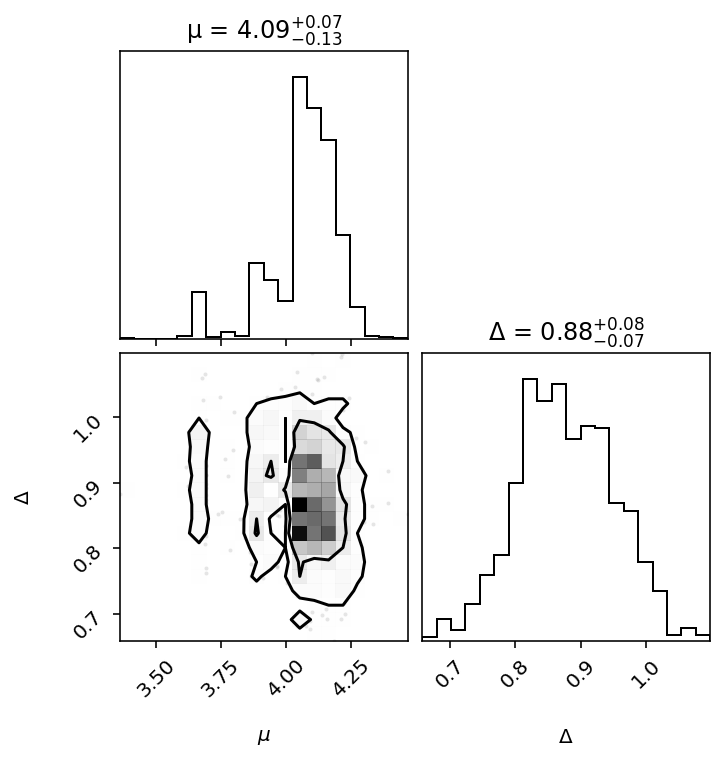

In [148]:
#putting all mu, delta values into their own arrays and combining all into 1 array
mus = [fit[0] for fit in best_fits]
deltas = [fit[1] for fit in best_fits]
Data = np.array([mus, deltas])

#corner plot of mu and delta
import corner
figure = corner.corner(Data.T, labels=[r"$\mu$", r"$\Delta$"],
                       levels=(0.68,0.95),
                       titles=['μ','Δ'],
                       title_kwargs={"fontsize": 12},
                       show_titles=True)

### Part 9

In [149]:
!pip install numdifftools

In [151]:
import numdifftools as nd

#original lines:
#H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
#sigma_laplace = np.linalg.inv(H)**0.5

#modified with my variables:
H = nd.Hessian(neg_ll)([opt[0], opt[1]])
sigma_laplace = np.linalg.inv(H)**0.5
print(sigma_laplace)

[[0.11216104 0.01522865]
 [0.01522865 0.08023095]]


Here the Fisher uncertainty is 0.11216104 for $\mu$ and 0.08023095 for $\Delta$. These agree fairly well with the distribution widths from (8), which were +0.07/-0.13 for $\mu$ and +0.08/-0.07 for $\Delta$.